In [1]:
import pickle
from typing import List, Any, Dict, Tuple, Set, Iterable, Sequence
from operator import itemgetter
from itertools import combinations, starmap, groupby, product, chain, islice

import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
import networkx as nx
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from conversant.conversation import Conversation
from conversant.interactions import InteractionsGraph
from conversant.interactions.interactions_graph import PairInteractionsData
from stance_classification.classifiers.base_stance_classifier import BaseStanceClassifier
from stance_classification.classifiers.greedy_stance_classifier import MSTStanceClassifier
from stance_classification.data.iac import FourForumInteractionsBuilder
from stance_classification.data.iac.fourforum_data import load_post_records, build_conversations
from stance_classification.data.iac.fourforum_labels import load_author_labels, AuthorLabel
from stance_classification.draw_utils import new_figure
%matplotlib inline

from stance_classification.classifiers.maxcut_stance_classifier import MaxcutStanceClassifier

In [2]:
data_path = "/home/dev/data/stance/IAC/alternative/fourforums"
records = tqdm(load_post_records(data_path))
# convs = list(islice(build_conversations(records), 100))
convs = list(build_conversations(records))

load quotes mapping



In [3]:
sizes = [c.size for c in convs]
print(len(sizes))
print(np.mean(sizes))
print(np.median(sizes))

11079
37.40888166802058
17.0


In [4]:
filtered_sizes = [s for s in sizes if s >= 10]
print(len(filtered_sizes))
print(np.mean(filtered_sizes))
print(np.median(filtered_sizes))

7165
55.2115840893231
32.0


## Load Author labels

In [5]:
def create_author_labels_dict(labels: Iterable[AuthorLabel]) -> Dict[Any, int]:
    return {l.author_id: (l.stance - 2) for l in labels if l.stance is not None}

path = "/home/dev/data/stance/IAC/alternative/fourforums/mturk_author_stance.txt"
author_labels = list(load_author_labels(path))
author_labels_per_conversation = {cid: create_author_labels_dict(labels) for cid, labels in groupby(author_labels, key=lambda a: a.discussion_id)}
author_labels_per_conversation = {k: v for k, v in author_labels_per_conversation.items() if len(v) > 0}
print(len(author_labels_per_conversation))
print(sum(len(v) for v in author_labels_per_conversation.values()))

324
4188


## Load posts labels (Chang Li)

In [6]:
def load_post_label_mapping(path: str) -> Dict[str, int]:
    with open(path, 'rb') as f:
        return pickle.load(f)

def decode_original_post_identification(post_id: str) -> Tuple[str, int, int]:
    topic, numeric_id = post_id.split('.')
    original_discussion_index = int(numeric_id[:-5])
    original_post_index = int(numeric_id[-3:])
    return topic, original_discussion_index, original_post_index


labels_path = "/home/dev/data/stance/chang-li/data/compressed-4forum/allPostLabelMap.pickle"
raw_post_labels = load_post_label_mapping(labels_path)
post_labels = {itemgetter(1,2)(decode_original_post_identification(raw_post_id)): (stance % 2) for (raw_post_id, stance) in raw_post_labels.items()}
len(post_labels)

24658

In [7]:
def get_author_labels(conv: Conversation) -> Dict[Any, int]:
    if conv.id not in author_labels_per_conversation:
        return None

    return author_labels_per_conversation[conv.id]

def get_maxcut_results(graph: InteractionsGraph, op: Any) -> MaxcutStanceClassifier:
    maxcut = MaxcutStanceClassifier(weight_field=graph.WEIGHT_FIELD)
    maxcut.set_input(graph.graph)
    maxcut.classify_stance(op)
    return maxcut

def get_greedy_results(graph: InteractionsGraph, op: Any) -> BaseStanceClassifier:
    clf = MSTStanceClassifier()#weight_field=graph.WEIGHT_FIELD)
    clf.set_input(graph.graph)
    clf.classify_stance(op)
    return clf

def align_gs_with_predictions(maxcut: MaxcutStanceClassifier, authors_labels: Dict[Any, int]) -> Tuple[List[int], List[int]]:
    support_label = authors_labels[op]
    opposer_label = 1 - support_label
    supporters = maxcut.get_supporters()
    opposers = maxcut.get_complement()

    y_true, y_pred = [], []
    for supporter in supporters:
        true_label = authors_labels.get(supporter)
        if true_label is not None:
            y_true.append(true_label)
            y_pred.append(support_label)

    for opposer in opposers:
        true_label = authors_labels.get(opposer)
        if true_label is not None:
            y_true.append(true_label)
            y_pred.append(opposer_label)

    return y_true, y_pred

def predict_for_partition(true: List[int], preds: List[int]) -> Tuple[List[int], List[int]]:
    acc = accuracy_score(true, preds)
    if acc < 0.5:
        preds = [1-l for l in preds]

    return true, preds

def predict_post_labels(conv: Conversation, post_labels: Dict[Any, int], supporters: Set[int], opposers: Set[int]) -> Tuple[List[int], List[int]]:
    y_true, y_pred = [], []
    conv_id = conv.id
    for depth, node in conv.iter_conversation():
        label = post_labels.get((conv_id, node.node_id), None)
        if label is None: continue

        author = node.author
        pred = 0 if author in supporters else 1 if author in opposers else None
        if pred is None: continue

        y_true.append(label)
        y_pred.append(pred)

    return y_true, y_pred


In [9]:
interactions_parser = FourForumInteractionsBuilder()
author_true, author_pred = [], []
author_true_partition, author_pred_partition = [], []
posts_true, posts_pred = [], []
post_true_partition, post_pred_partition = [], []
filtered_convs = []
full_graphs = []
core_graphs = []
maxcut_results: List[MaxcutStanceClassifier] = []
classification_results: List[Tuple[List[int], List[int]]] = []
empty_core = []
unlabeled_conversations = []
unlabeled_op = []
insufficient_author_labels = []
too_small_cut_value = []
op_not_in_core = []
large_graphs = []

def calc_weight(interactions: PairInteractionsData) -> float:
    n_replies = interactions["replies"]
    n_quotes = interactions["quotes"]
    return (0.02 * n_replies) + n_quotes
    # return n_quotes

"""abortion = 3
   evolution = 7
   gay marriage = 8
   gun control = 9
   """
# convs[0].root.data["topic"]
# conv: Conversation
relevant_topics = {3,7,8,9}
count_conv = 0
for conv in tqdm(convs):
    topic = conv.root.data["topic"]
    if topic not in relevant_topics: continue
    count_conv += 1
    authors_labels = get_author_labels(conv)
    if authors_labels is None:
        unlabeled_conversations.append(conv)
        continue

    op = conv.root.author
    if op not in authors_labels:
        unlabeled_op.append(conv)
        continue

    if len(authors_labels) < 3:
        insufficient_author_labels.append(conv)
        continue

    interaction_graph = interactions_parser.build(conv)

    interaction_graph.set_interaction_weights(calc_weight)
    zero_edges = [(v, u) for v, u, d in interaction_graph.graph.edges(data=True) if d["weight"] == 0]
    interaction_graph.graph.remove_edges_from(zero_edges)

    core_interactions = interaction_graph.get_core_interactions()
    if op not in core_interactions.graph.nodes:
        op_not_in_core.append(conv)
        continue

    core_interactions = core_interactions.get_op_connected_components()
    if core_interactions.graph.size() < 2:
            empty_core.append(conv)
            continue

    # if core_interactions.graph.order() > 120:
    #     large_graphs.append(conv)
    #     continue

    maxcut = get_greedy_results(core_interactions, op)
    # maxcut = get_maxcut_results(core_interactions, op)
    # if maxcut.cut_value < 3:
    #     too_small_cut_value.append(conv)
    #     continue

    true, preds = align_gs_with_predictions(maxcut, authors_labels)
    author_true.append(true)
    author_pred.append(preds)

    true, preds = predict_for_partition(true, preds)
    author_true_partition.append(true)
    author_pred_partition.append(preds)

    true, preds = predict_post_labels(conv, post_labels, maxcut.get_supporters(), maxcut.get_complement())
    posts_true.append(true)
    posts_pred.append(preds)

    true, preds = predict_for_partition(true, preds)
    post_true_partition.append(true)
    post_pred_partition.append(preds)

    filtered_convs.append(conv)
    full_graphs.append(interaction_graph)
    core_graphs.append(core_interactions)
    maxcut_results.append(maxcut)
    classification_results.append((true, preds))

In [1]:
print(f"total number of conversations (in all topics): {len(convs)}")
print(f"total number of conversations (in the relevant topics): {count_conv}")
print(f"total number of conversations with labeled authors (in all topics): {len(author_labels_per_conversation)}")
print(f"total number of conversations with labeled authors (in the relevant topics): {count_conv - len(unlabeled_conversations)}")

print(f"number of conversations in eval: {len(filtered_convs)}")
labeled_authors = sum(len(v) for v in author_labels_per_conversation.values())
print(f"total number of labeled authors: {labeled_authors}")
print(f"number of authors in eval: {sum(map(len, author_true))}")
print(f"number of posts in eval: {sum(map(len, posts_true))}")
print("=========")
print(f"number of conversations with empty core: {len(empty_core)}")
print(f"number of conversations with op not in core: {len(op_not_in_core)}")
print(f"number of conversations with too large core: {len(large_graphs)}")
print(f"number of conversations with too small cut value: {len(too_small_cut_value)}")
print(f"number of unlabeled conversations: {len(unlabeled_conversations)}")
print(f"number of conversations with unlabeled op: {len(unlabeled_op)}")
print(f"number of conversations with insufficient labeled authors: {len(insufficient_author_labels)}")

NameError: name 'convs' is not defined

In [2]:
y_true = list(chain(*author_true))
y_pred = list(chain(*author_pred))
print(classification_report(y_true, y_pred))

NameError: name 'chain' is not defined

In [3]:
y_pred = [l%2 for l in list(chain(*post_true_partition))]
y_true = list(chain(*post_pred_partition))
print(classification_report(y_true, y_pred))

NameError: name 'chain' is not defined

In [37]:
def compute_pairs_average_distance(
        pairs: Iterable[Tuple[int, int]],
        embeddings: Sequence[np.ndarray]
) -> float:
    distances = list(starmap(lambda i, j: cosine(embeddings[i], embeddings[j]), pairs))
    return float(np.mean(distances))


def compute_average_angle_from_node(
        node_index: int,
        group_indices: Sequence[int],
        embeddings: Sequence[np.ndarray]
) -> float:
    pairs = ((node_index, i) for i in group_indices)
    return compute_pairs_average_distance(pairs, embeddings)


def compute_group_average_angle(
        group_indices: Sequence[int],
        embeddings: Sequence[np.ndarray]
) -> float:
    pairs = combinations(group_indices, 2)
    return compute_pairs_average_distance(pairs, embeddings)


def compute_cross_groups_average_angle(
        group1: Sequence[int],
        group2: Sequence[int],
        embeddings: Sequence[np.ndarray]
) -> float:
    pairs = product(group1, group2)
    return compute_pairs_average_distance(pairs, embeddings)

In [38]:

supporters_avg_angles = []
opposers_avg_angles = []
mean_cross_angle = []
op2supporters = []
op2opposers = []
for i in range(len(maxcut_results)):
    maxcut = maxcut_results[i]
    op, all_embeddings, supporters, opposers =\
        maxcut.op, maxcut.embeddings, maxcut.get_supporters(), maxcut.get_complement()

    op2supporters.append(compute_average_angle_from_node(op, supporters, all_embeddings))
    op2opposers.append(compute_average_angle_from_node(op, opposers, all_embeddings))

    supporters_avg_angles.append(compute_group_average_angle(supporters, all_embeddings))
    opposers_avg_angles.append(compute_group_average_angle(opposers, all_embeddings))

    mean_cross_angle.append(compute_cross_groups_average_angle(supporters, opposers, all_embeddings))

print(f"total conversations {len(maxcut_results)}")
print(f"supporters avg. cosine {np.nanmean(supporters_avg_angles)}")
print(f"opposers avg. cosine {np.nanmean(opposers_avg_angles)}")
print(f"cross groups avg. cosine {np.mean(mean_cross_angle)}")
print(f"op to supporters avg. cosine {np.mean(op2supporters)}")
print(f"op to opposers avg. cosine {np.mean(op2opposers)}")

/home/dev/.virtualenvs/conv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dev/.virtualenvs/conv/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


total conversations 164
supporters avg. cosine 0.22229970047504644
opposers avg. cosine 0.2080881072602255
cross groups avg. cosine 1.8027991463607387
op to supporters avg. cosine 0.16995777037925208
op to opposers avg. cosine 1.8269398784768645


In [39]:
strong_convs_indices = []
for i in range(len(filtered_convs)):
    op2s = op2supporters[i]
    op2o = op2opposers[i]
    if op2supporters[i] * op2opposers[i] == 0:
        continue

    diff = op2o - op2s
    ratio = op2o / op2s
    if (ratio > 2) and (diff > 1):
        strong_convs_indices.append(i)

len(strong_convs_indices)


152

In [40]:
# strong_true, strong_preds = zip(*[classification_results[i] for i in strong_convs_indices])
# strong_true = list(chain(*strong_true))
# strong_preds = list(chain(*strong_preds))
strong_true = list(chain(*[author_true[i] for i in strong_convs_indices]))
strong_preds = list(chain(*[author_pred[i] for i in strong_convs_indices]))
print(classification_report(strong_true, strong_preds))

              precision    recall  f1-score   support

           0       0.85      0.78      0.82      1121
           1       0.72      0.80      0.76       774

    accuracy                           0.79      1895
   macro avg       0.78      0.79      0.79      1895
weighted avg       0.80      0.79      0.79      1895



In [41]:
max_i = 0
max_shape = 0
# sizes = [(i, g.graph.order()) for i, g  in enumerate(core_graphs)]
sizes = [(i, core_graphs[i].graph.order()) for i in strong_convs_indices]
sorted_sized = sorted(sizes, key=itemgetter(1), reverse=True)
sorted_sized[:20]

[(73, 37),
 (151, 36),
 (29, 32),
 (68, 32),
 (124, 32),
 (83, 31),
 (119, 28),
 (70, 27),
 (26, 26),
 (160, 26),
 (133, 25),
 (148, 25),
 (7, 24),
 (145, 24),
 (22, 23),
 (51, 23),
 (13, 22),
 (47, 22),
 (60, 22),
 (117, 22)]

In [42]:
strong_convs_indices

[0,
 1,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 12,
 13,
 14,
 15,
 16,
 17,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 87,
 88,
 90,
 91,
 92,
 93,
 94,
 95,
 98,
 99,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163]

In [44]:
result_index = 17

maxcut = maxcut_results[result_index]
op, emb, supporters, opposers = maxcut.op, maxcut.embeddings, maxcut.get_supporters(), maxcut.get_complement()

s_cosine = compute_group_average_angle(supporters, emb)
o_cosine = compute_group_average_angle(opposers, emb)
cross_cosine = compute_cross_groups_average_angle(supporters, opposers, emb)
op2support = compute_average_angle_from_node(op, supporters, emb)
op2oppose = compute_average_angle_from_node(op, opposers, emb)
print(f"num supporters: {len(supporters)}")
print(f"num opposers: {len(opposers)}")
print(f"supporters avg. cosine: {s_cosine}")
print(f"opposers avg. cosine: {o_cosine}")
print(f"cross-groups avg. cosine: {cross_cosine}")
print(f"op <-> supporters avg. cosine: {op2support}")
print(f"op <-> opposers avg. cosine: {op2oppose}")
print(f"supporters - opposers diff cosine with op: {op2oppose - op2support}")
print(f"supporters - opposers ratio cosine with op: {op2oppose / op2support}")

num supporters: 4
num opposers: 7
supporters avg. cosine: 2.631841411471214e-10
opposers avg. cosine: 4.451386666678066e-10
cross-groups avg. cosine: 1.9999999996740587
op <-> supporters avg. cosine: 2.0087248531197588e-10
op <-> opposers avg. cosine: 1.9999999997371412
supporters - opposers diff cosine with op: 1.9999999995362687
supporters - opposers ratio cosine with op: 9956565214.150326


#### Author classification results
For the current conversation

In [49]:
true = author_true[result_index]
preds = author_pred[result_index]
print(classification_report(true, preds))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.80      0.80      0.80         5

    accuracy                           0.78         9
   macro avg       0.78      0.78      0.78         9
weighted avg       0.78      0.78      0.78         9



In [48]:
true = author_true_partition[result_index]
preds = author_pred_partition[result_index]
print(classification_report(true, preds))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.80      0.80      0.80         5

    accuracy                           0.78         9
   macro avg       0.78      0.78      0.78         9
weighted avg       0.78      0.78      0.78         9



#### Post classification results
For the current conversation

In [46]:
true = posts_true[result_index]
preds = posts_pred[result_index]
print(classification_report(true, preds))


              precision    recall  f1-score   support

           0       0.93      0.87      0.90        15
           1       0.83      0.91      0.87        11

    accuracy                           0.88        26
   macro avg       0.88      0.89      0.88        26
weighted avg       0.89      0.88      0.89        26



#### Post partition classification results
For the current conversation

In [50]:
true = post_true_partition[result_index]
preds = post_pred_partition[result_index]
print(classification_report(true, preds))



              precision    recall  f1-score   support

           0       0.93      0.87      0.90        15
           1       0.83      0.91      0.87        11

    accuracy                           0.88        26
   macro avg       0.88      0.89      0.88        26
weighted avg       0.89      0.88      0.89        26



In [51]:
conv = filtered_convs[result_index]
author_labels = get_author_labels(conv)
true_supporters = [n for n, l in author_labels.items() if l == 1]
true_opposers = [n for n, l in author_labels.items() if l == 0]
unknown_labels = set(author_labels.keys()) - (set(supporters) | set(opposers))
len(author_labels), len(true_opposers), len(true_supporters), len(unknown_labels)

(12, 6, 6, 3)

[1.01818182e+00 1.15306964e-10]


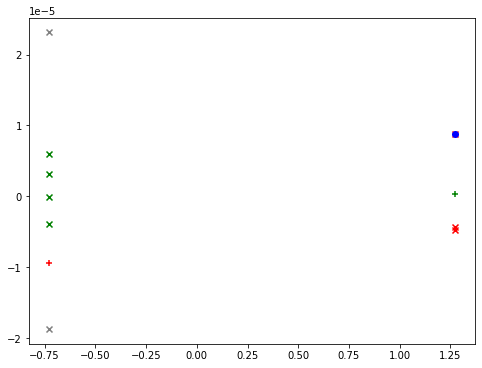

In [55]:
plt.figure(figsize=(8,6))


X = np.vstack([np.array(x) for x in emb.values()])
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)
# X_2d = TSNE(n_components=2).fit_transform(X)
print(pca.explained_variance_)
op = maxcut.op
nodes = emb.keys()
tp_supporters_indices = [i for i, n in enumerate(nodes) if n in true_supporters and n in supporters]
fn_supporters_indices = [i for i, n in enumerate(nodes) if n in true_supporters and n in opposers]
tp_opposers_indices = [i for i, n in enumerate(nodes) if n in true_opposers and n in opposers]
fn_opposers_indices = [i for i, n in enumerate(nodes) if n in true_opposers and n in supporters]
unlabeled_supporters = [i for i, n in enumerate(nodes) if n not in author_labels and n in supporters]
unlabeled_opposers = [i for i, n in enumerate(nodes) if n not in author_labels and n in opposers]

op_index = [i for i, n in enumerate(nodes) if n == op]

plt.scatter(X_2d[tp_supporters_indices, 0], X_2d[tp_supporters_indices, 1], color='g', marker='+')
plt.scatter(X_2d[fn_supporters_indices, 0], X_2d[fn_supporters_indices, 1], color='g', marker='x')
plt.scatter(X_2d[tp_opposers_indices, 0], X_2d[tp_opposers_indices, 1], color='r', marker='+')
plt.scatter(X_2d[fn_opposers_indices, 0], X_2d[fn_opposers_indices, 1], color='r', marker='x')
plt.scatter(X_2d[unlabeled_supporters, 0], X_2d[unlabeled_supporters, 1], color='grey', marker='+')
plt.scatter(X_2d[unlabeled_opposers, 0], X_2d[unlabeled_opposers, 1], color='grey', marker='x')
plt.scatter([X_2d[op_index, 0]], [X_2d[op_index, 1]], color='b', marker='o')

# colors = ['b' if i == op else 'g' if i in supporters else 'r' for i in nodes]
# markers = ['o' if i ==op else 'x' if i in supporters else '+' for i in nodes]
# plt.scatter(X_2d[:, 0], X_2d[:, 1], color=colors)
# op_index = [i for i, n  in enumerate(nodes) if n == op][0]

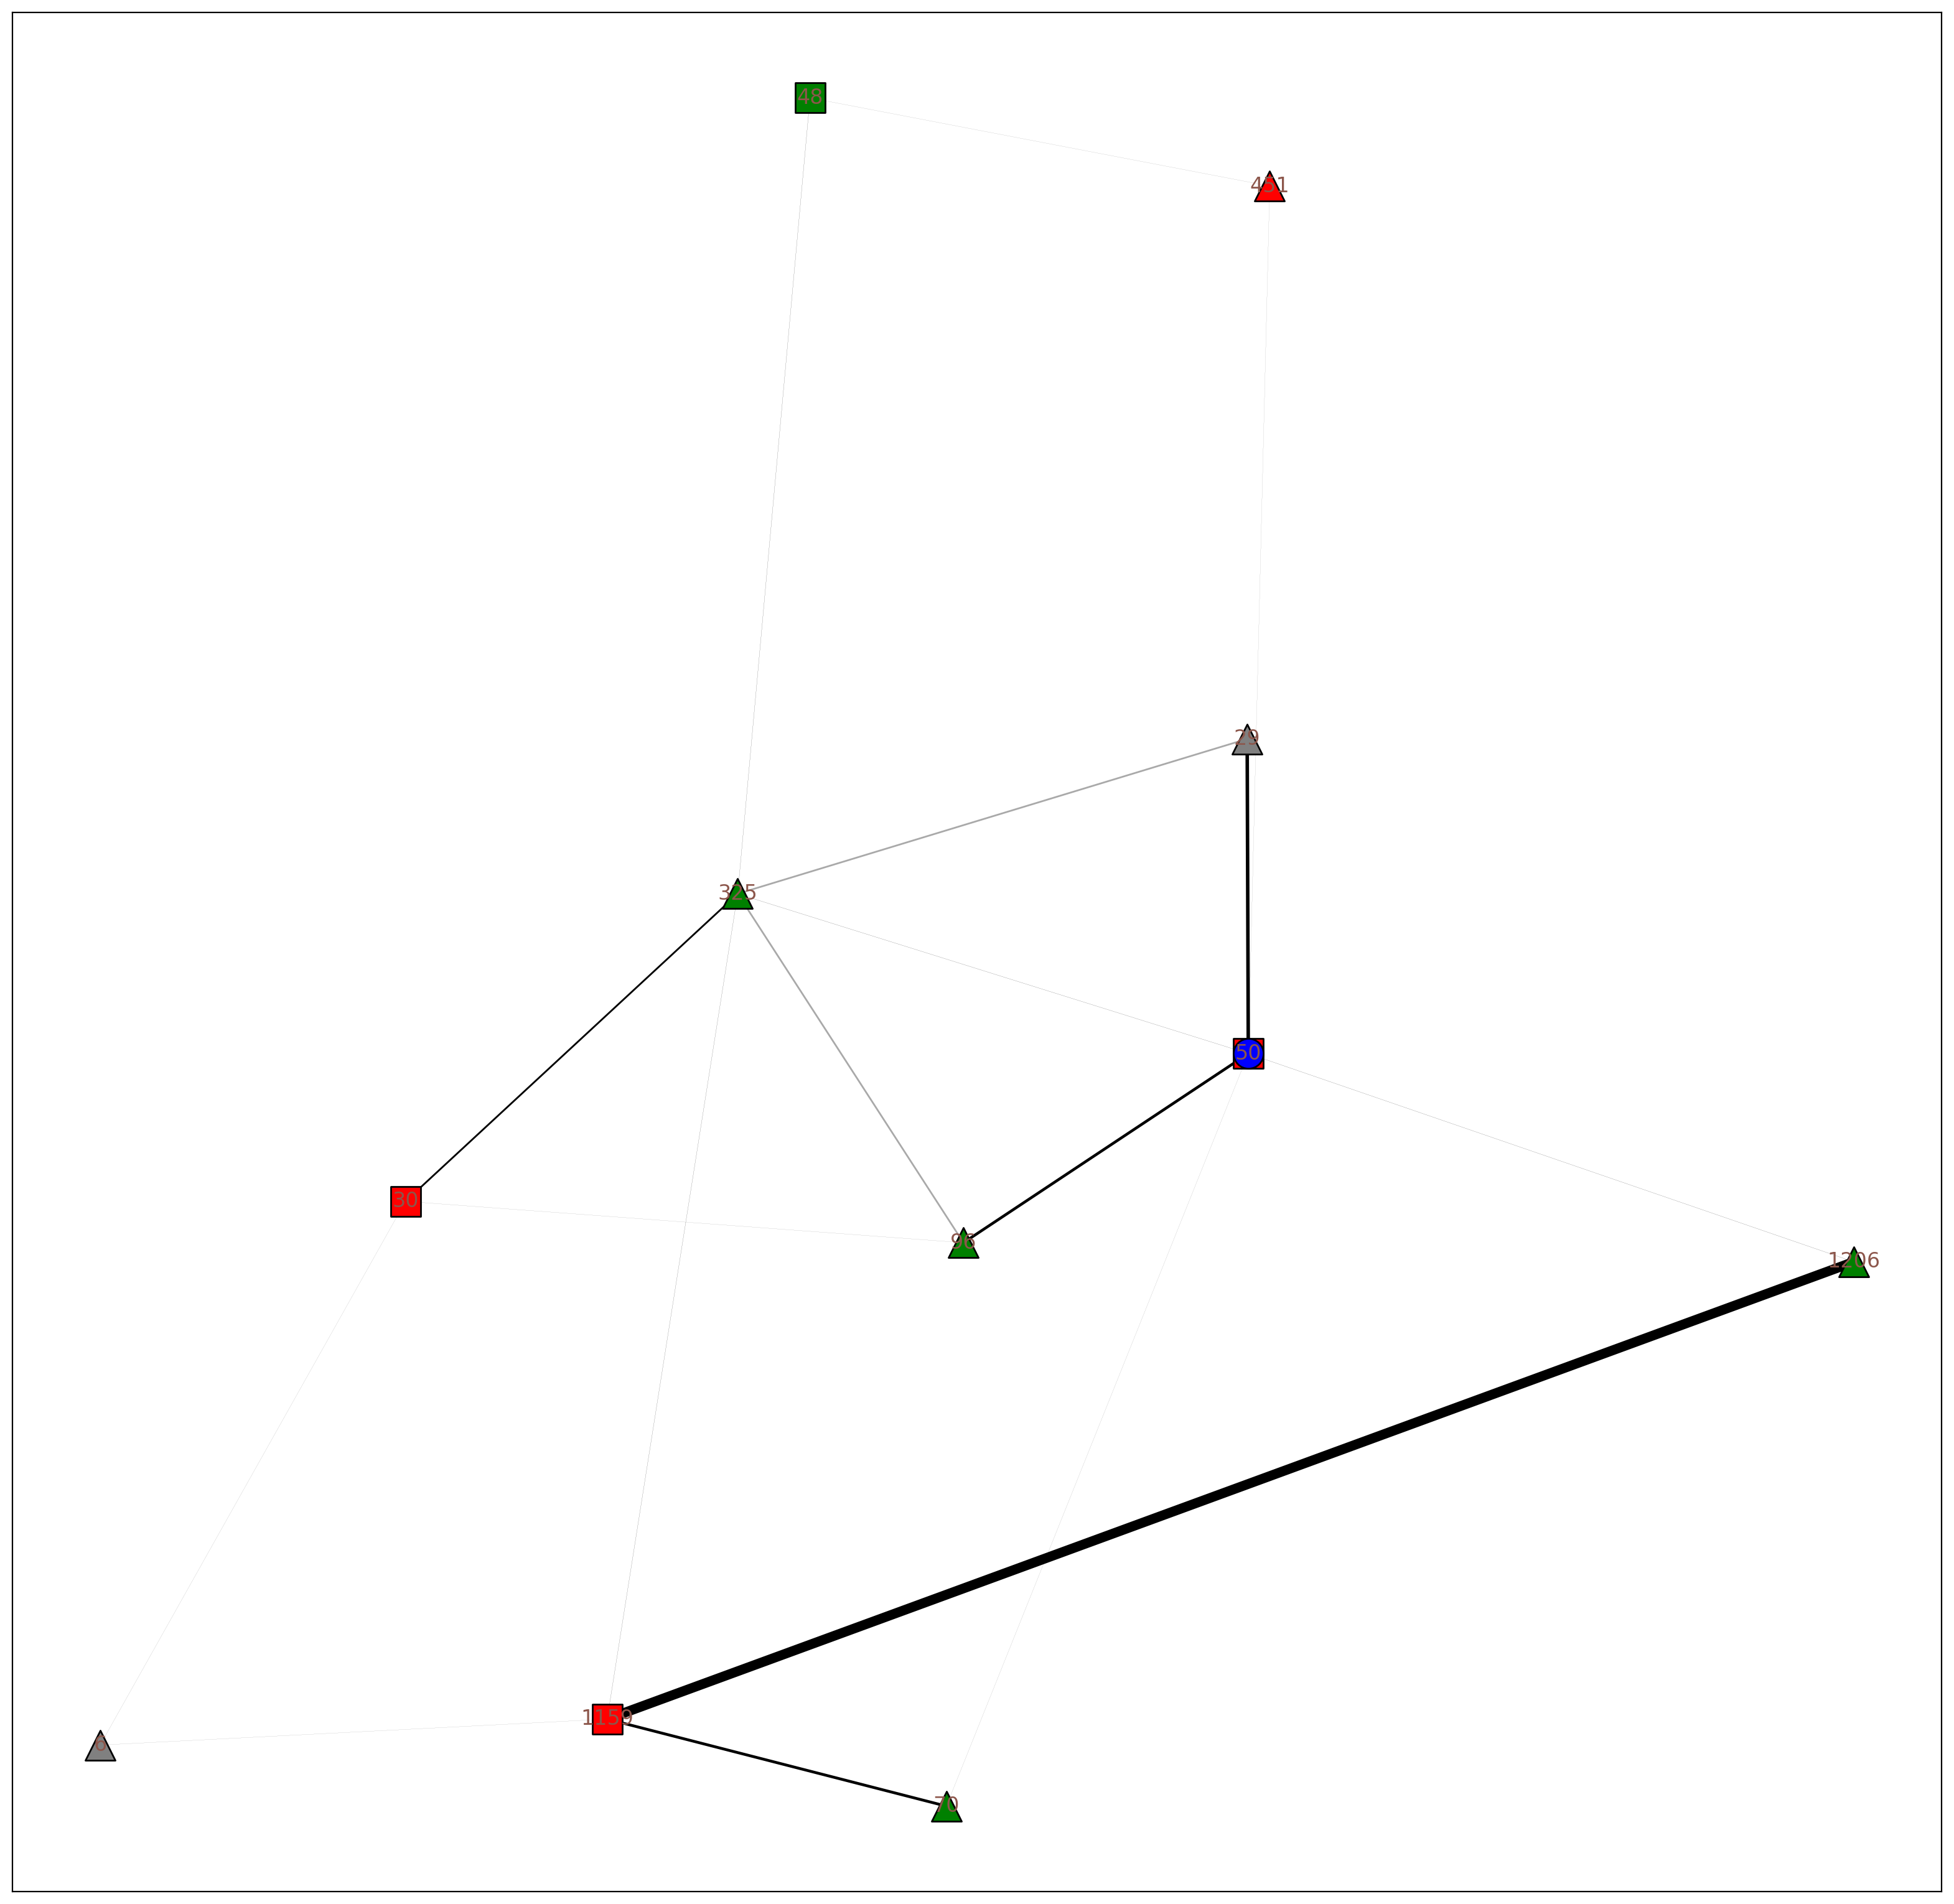

In [53]:
new_figure()
graph = maxcut.graph
pos = nx.spring_layout(graph)

all_nodes = list(nodes)
tps = [all_nodes[i] for i in tp_supporters_indices]
fns = [all_nodes[i] for i in fn_supporters_indices]
fno = [all_nodes[i] for i in fn_opposers_indices]
tpo = [all_nodes[i] for i in tp_opposers_indices]
unks = [all_nodes[i] for i in unlabeled_supporters]
unko = [all_nodes[i] for i in unlabeled_opposers]
op = [all_nodes[i] for i in op_index]

nx.draw_networkx_nodes(graph, pos, nodelist=tps, node_color='g', node_shape='s', edgecolors="black")
nx.draw_networkx_nodes(graph, pos, nodelist=fns, node_color='g', node_shape='^', edgecolors="black")
nx.draw_networkx_nodes(graph, pos, nodelist=fno, node_color='r', node_shape='s', edgecolors="black")
nx.draw_networkx_nodes(graph, pos, nodelist=tpo, node_color='r', node_shape='^', edgecolors="black")
nx.draw_networkx_nodes(graph, pos, nodelist=unks, node_color='grey', node_shape="s", edgecolors="black")
nx.draw_networkx_nodes(graph, pos, nodelist=unko, node_color='grey', node_shape="^", edgecolors="black")
nx.draw_networkx_nodes(graph, pos, nodelist=op, node_color='b', node_shape='o', edgecolors="black")

node_labels = {n: str(n) for n in graph.nodes}
nx.draw_networkx_labels(graph, pos, labels=node_labels, font_color="tab:brown")

# Draw the edges that are in the cut.
edge_weights = [np.log2(graph[e[0]][e[1]]['weight']) for e in maxcut.cut]
nx.draw_networkx_edges(graph, pos, edgelist=maxcut.cut, edge_color="black", width=edge_weights)
#
# # Draw the edges that are not in the cut
leave = [e for e in graph.edges if e not in maxcut.cut]
non_cut_weigths = [np.log2(graph[e[0]][e[1]]['weight']) for e in leave]
nx.draw_networkx_edges(graph, pos, edgelist=leave, edge_color="darkgray")

{30: 0, 48: 1, 50: 0, 70: 1, 96: 1, 186: 0, 325: 1, 451: 0, 786: 1, 1159: 0, 1206: 1, 1216: 0}


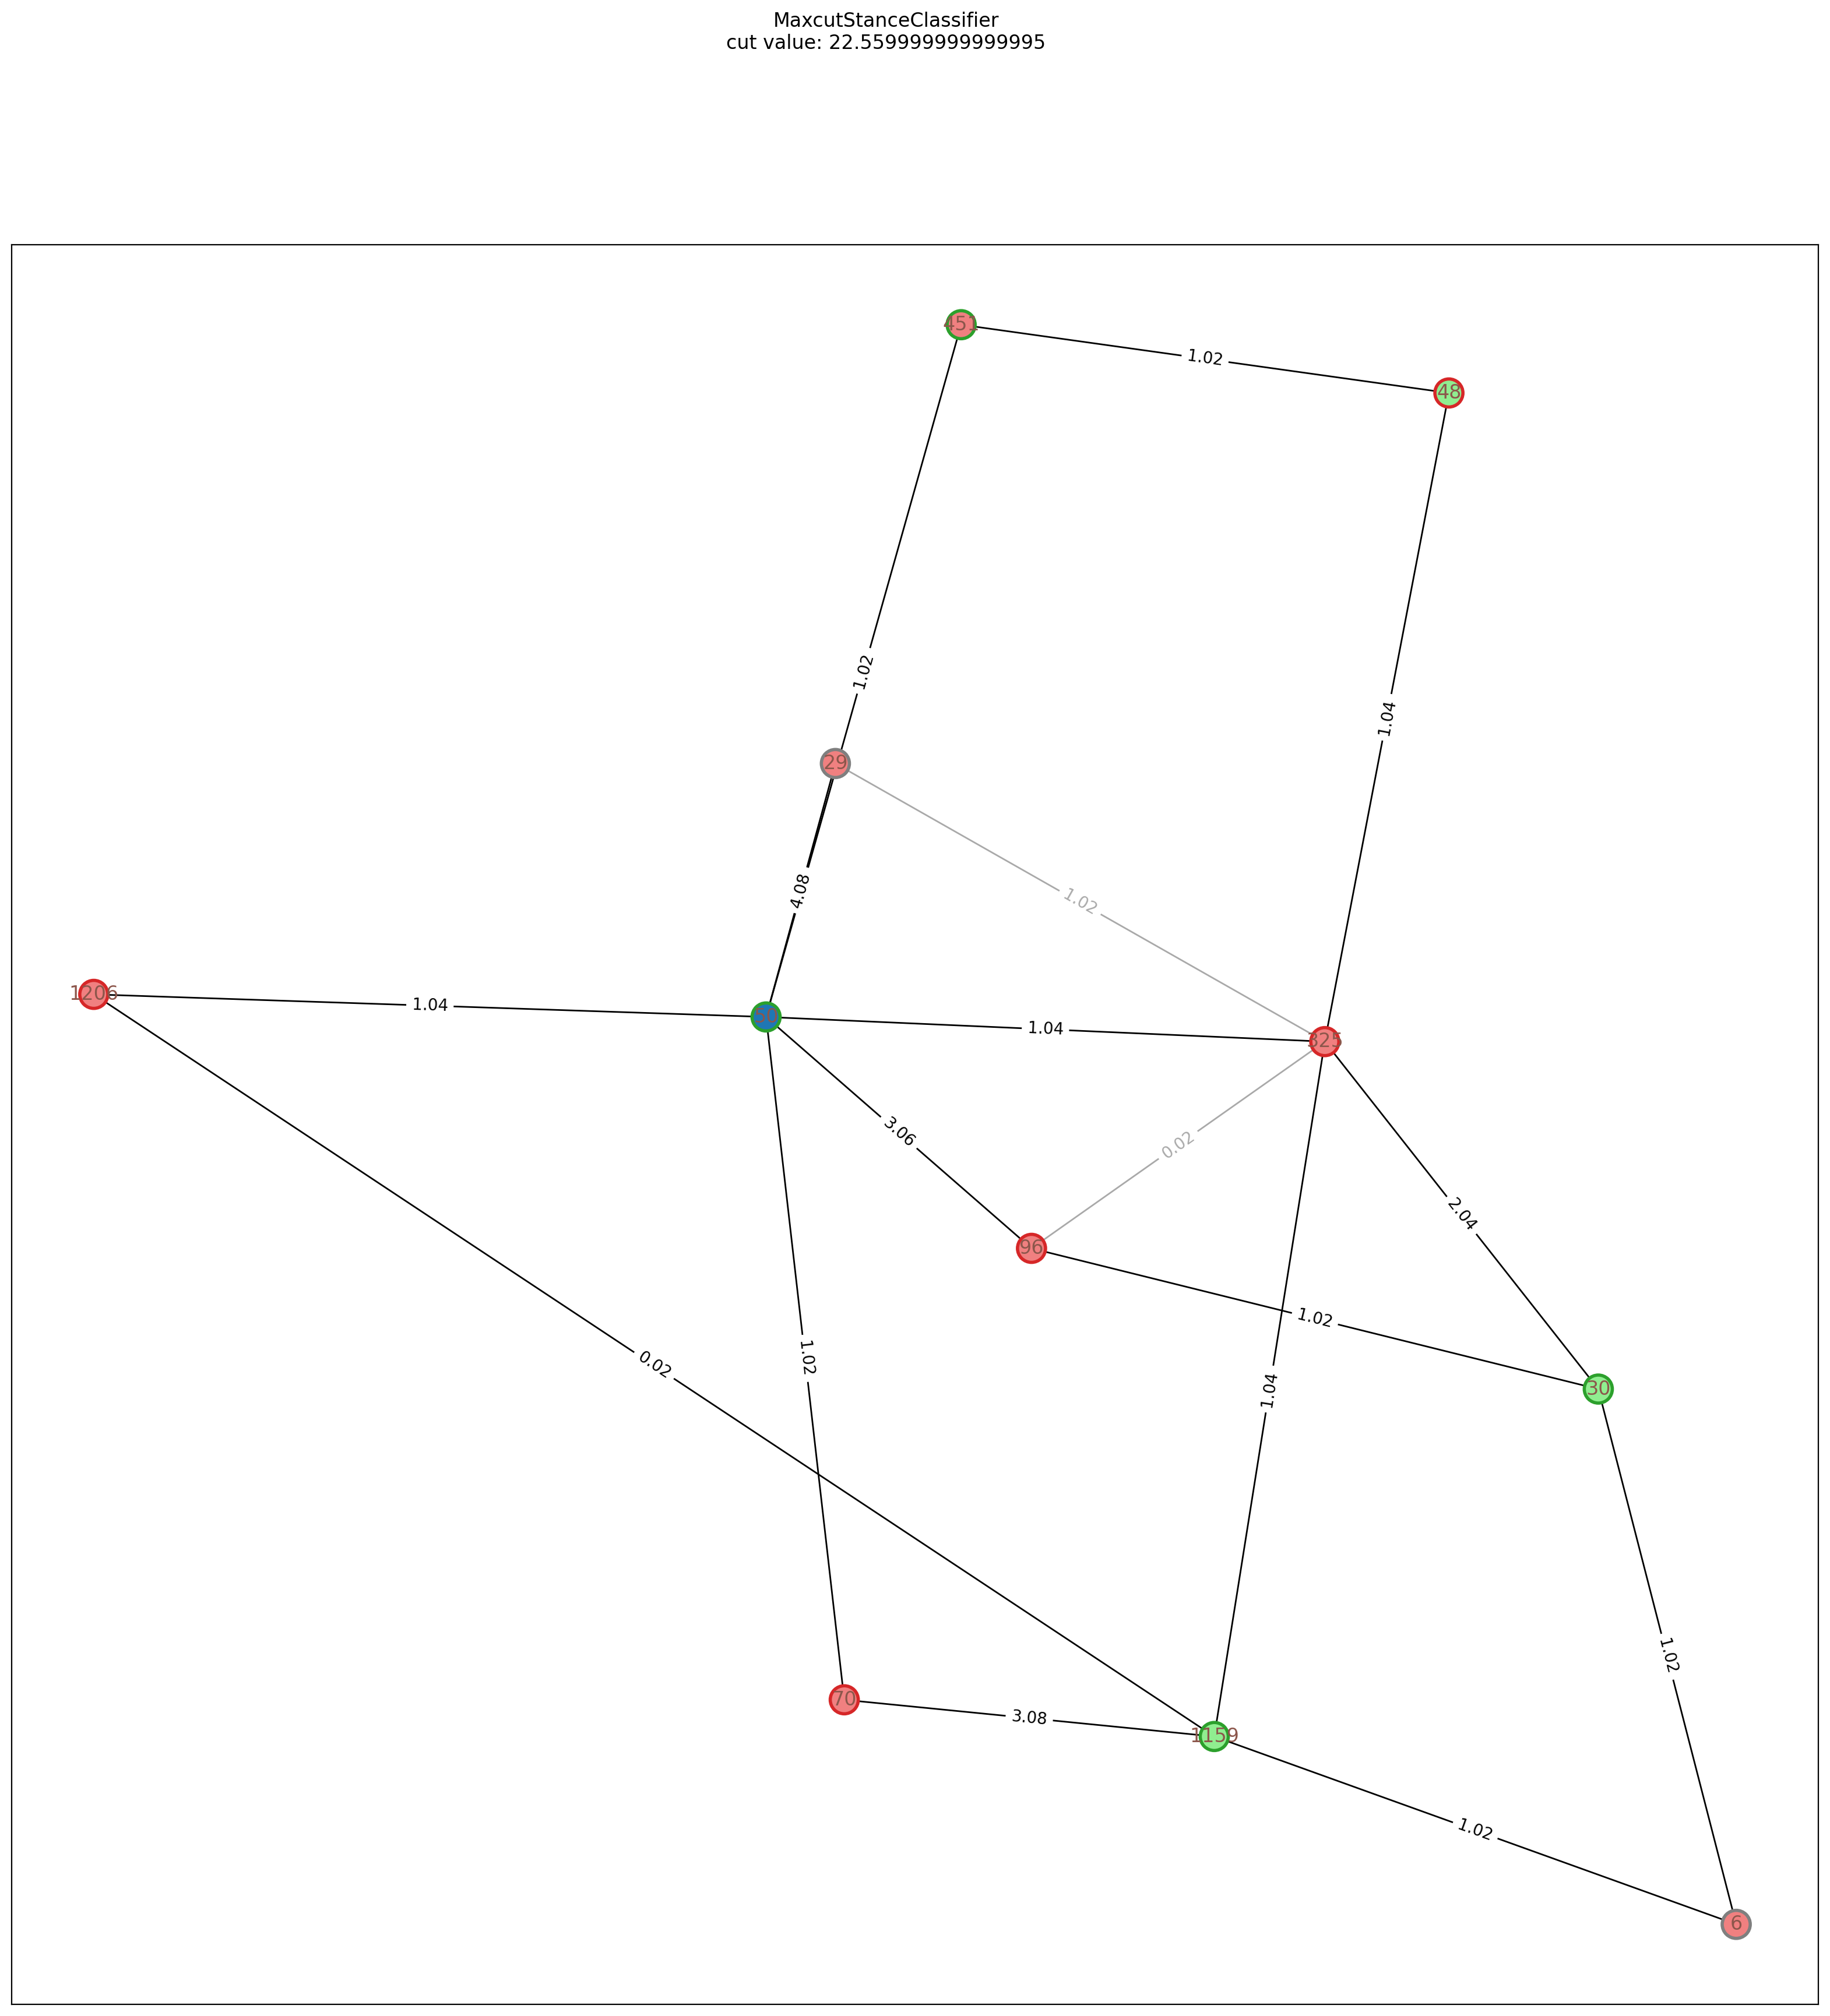

In [54]:


conv_id = filtered_convs[result_index].id
author_labels = author_labels_per_conversation[conv_id]
print(author_labels)
maxcut.draw(true_labels=author_labels)

In [ ]:
full_graph = full_graphs[result_index]
layout = nx.spring_layout(full_graph.graph)
nx.draw(full_graph.graph, layout)

In [ ]:
kcore = core_graphs[result_index]
layout = nx.spring_layout(kcore.graph)
nx.draw(kcore.graph, layout)

kcore.graph.order()


# Evaluating Post-Level

## Loading posts labels


In [ ]:
## Predicting posts labels




